<a href="https://colab.research.google.com/github/KseniiaTsyganova/bewise_test_task/blob/main/bewise_test_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание bewise.ai

Позиция "Junior Data Scientist (NLP)".

Главные задачи, которые должен выполнять скрипт:

a. Извлекать реплики с приветствием – где менеджер поздоровался.

b. Извлекать реплики, где менеджер представил себя.

c. Извлекать имя менеджера.

d. Извлекать название компании.

e. Извлекать реплики, где менеджер попрощался.

f. Проверять требование к менеджеру: «В каждом диалоге обязательно необходимо поздороваться и попрощаться с клиентом

# Часть 1

Начнем с импорта необходимых библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re # библиотека для работы с регулярными выражениями
import time 
import pymorphy2 #библиотека для лемматизации
import numpy as np

from wordcloud import WordCloud #модуль для создания облака слов
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score

import tensorflow as tf

import warnings 
warnings.filterwarnings('ignore')

Загрузим данные

In [ ]:
df = pd.read_csv('test_data.csv')

In [ ]:
df.head()

,dlg_id,line_n,role,text
0,0,0,client,Алло
1,0,1,manager,Алло здравствуйте
2,0,2,client,Добрый день
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес з...
4,0,4,client,Ага


In [ ]:
#Создаем копию исходного датафрейма для дальнейших манипуляций

data = df.copy()

In [ ]:
# Посмотрим информацию о датафрейме

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dlg_id  480 non-null    int64 
 1   line_n  480 non-null    int64 
 2   role    480 non-null    object
 3   text    480 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.1+ KB


Проверим данные на пропуски.

In [ ]:
data.isna().sum()

dlg_id    0
line_n    0
role      0
text      0
dtype: int64

Проверим на наличие дубликатов в данных.

In [ ]:
data.duplicated().sum()

0

Визуализируем количество реплик в каждом диалоге.

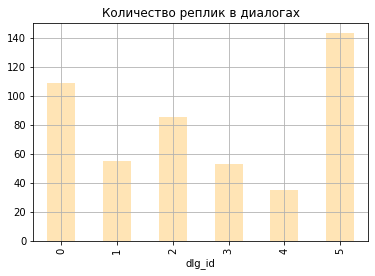

In [ ]:
data.groupby('dlg_id')['line_n'].count().plot(kind='bar', title='Количество реплик в диалогах', color='moccasin')
plt.grid()
plt.show()

Убедимся, что реплики располагаются по порядку.

In [ ]:
data = data.sort_values(by=['dlg_id', 'line_n'], ascending=[True, True])
data.head(20)

,dlg_id,line_n,role,text
0,0,0,client,Алло
1,0,1,manager,Алло здравствуйте
2,0,2,client,Добрый день
3,0,3,manager,Меня зовут ангелина компания диджитал бизнес з...
4,0,4,client,Ага
5,0,5,manager,Угу ну возможно вы рассмотрите и другие вариан...
6,0,6,client,Да мы работаем с компанией которая нам подлива...
7,0,7,client,Как как бы уже до этого момента работаем все у...
8,0,8,manager,Угу а на что вы обращаете внимание при выборе
9,0,9,client,Как бы нет


Для начала проверим, есть ли сочитания Имя+Фамилия с большой буквы во всех репликах.

In [ ]:
# регулярка 
reg_expr = r'[А-Я]{1}[а-я]+\s+[А-Я]{1}[а-я]\w+'

# компилируем регулярное выражение
reg_expr_compiled = re.compile(reg_expr)
# применяем выражение к тексту
for raw_text in data.text.values:
    for g in reg_expr_compiled.findall(raw_text):
        print(g)

Ничего не нашлось, судя по всему, в тексте имена пишутся с маленькой буквы. Поэтому мы ничего не потеряем, если приведем данные к нижнему регистру.

In [ ]:
data.text = data.text.apply(lambda x: x.lower())

In [ ]:
data.sample(10)

,dlg_id,line_n,role,text
80,0,80,client,алло
208,2,44,manager,угу
137,1,28,manager,да вот где раздел как для админа там вам нужно...
16,0,16,client,совершенно верно да и вот так вот делает еще 5...
239,2,75,manager,у вас в любое время есть с какого по какого
451,5,114,manager,сейчас со мной с претензиями закончились ну в ...
38,0,38,client,не могу сказать я прошу прощения просто я да т...
307,4,5,client,ну в принципе да
192,2,28,client,так значит у вас пишет и все
475,5,138,manager,по поводу виджетов и с ними уже обсудите конкр...


Так как мы будем анализировать фразы менеджеров, извлечем только их реплики для удобства.

In [ ]:
data_manager = data[data.role == 'manager']

In [ ]:
data_manager.sample(10)

,dlg_id,line_n,role,text
170,2,6,manager,удобно вам сейчас говорить что я вам так расск...
398,5,61,manager,да все верно то есть я вам просто сейчас выста...
343,5,6,manager,так да да хорошо смотрите давайте по порядку
448,5,111,manager,то есть это уже будете обсуждать с ним и если ...
235,2,71,manager,не перепутала оставлю тогда на ватсап хорошо а...
144,1,35,manager,так в очень странно мне просто указано 8 может...
218,2,54,manager,да конечно вам на ватсап или на почту
370,5,33,manager,с вами уже свяжется человек который непосредст...
253,3,4,manager,да дмитрий вот мне моя коллега анастасия подск...
197,2,33,manager,угу


Приступаем к выполнению заданий.

**a. Извлекать реплики с приветствием – где менеджер поздоровался.**

Попытаемся найти различные варианты приветствий. 

In [ ]:
reg_exprs = [(r'\w+дравствуйте', 'Здравствуйте'), (r'\w+обрый+\s+\w+', 'Добрый день/вечер'), (r'\w+ривет', 'Привет')]

def greeting_search(reg_expr, number_list):
    '''
    Принимает на вход регулярное выражение и список с индексами строк, 
    ищет новые строки, соответсвующие регулярному выражению,
    считает количество вхождений,
    возвращает дополненный список с индексами, если новые строки нашлись по условию.
    '''
    
    # компилируем регулярное выражение
    reg_expr_compiled = re.compile(reg_expr[0])
    count = 0
    
    print('Ищем приветствие: ', reg_expr[1])
    print()
    
    # применяем выражение к тексту
    for i, raw_text in enumerate(data_manager.text.values):
        for g in reg_expr_compiled.findall(raw_text):
            print(g)
            ind = data_manager.index.values[i]
            number_list.append(ind)
            count += 1
            
    print()
    if count > 0:
        print(f'Нашлось {count} реплики менеджеров с таким приветствием.')
        print()
        print()
    else:
        print('Таких варантов приветствий у менеджеров не нашлось.')
        print()
        print()
    return number_list
    
    

In [ ]:
number_list = []

for expr in reg_exprs:
    greeting_search(expr, number_list)

Ищем приветствие:  Здравствуйте

здравствуйте
здравствуйте
здравствуйте

Нашлось 3 реплики менеджеров с таким приветствием.


Ищем приветствие:  Добрый день/вечер

добрый день
добрый меня

Нашлось 2 реплики менеджеров с таким приветствием.


Ищем приветствие:  Привет


Таких варантов приветствий у менеджеров не нашлось.




In [ ]:
number_list

[1, 110, 166, 250, 251]

Теперь создадим столбец в датасете, содержащий флаг приветствия.

In [ ]:
index_dict = dict(zip(range(len(data)), [0]*len(data)))

In [ ]:
for i in number_list:
    index_dict[i] = 1

In [ ]:
data['is_greetings'] = list(index_dict.values())

In [ ]:
data.head(10)

,dlg_id,line_n,role,text,is_greetings
0,0,0,client,алло,0
1,0,1,manager,алло здравствуйте,1
2,0,2,client,добрый день,0
3,0,3,manager,меня зовут ангелина компания диджитал бизнес з...,0
4,0,4,client,ага,0
5,0,5,manager,угу ну возможно вы рассмотрите и другие вариан...,0
6,0,6,client,да мы работаем с компанией которая нам подлива...,0
7,0,7,client,как как бы уже до этого момента работаем все у...,0
8,0,8,manager,угу а на что вы обращаете внимание при выборе,0
9,0,9,client,как бы нет,0


**b. Извлекать реплики, где менеджер представил себя.**

Попробуем разные конструкции.

In [ ]:
# регулярка 
reg_expr_1 = r'\w+еня зовут+\s\w+'
number_list = []
index_name_dict = dict()

In [ ]:
# компилируем регулярное выражение
reg_expr_compiled = re.compile(reg_expr_1)

# применяем выражение к тексту
for i, raw_text in enumerate(data_manager.text.values):
    for g in reg_expr_compiled.findall(raw_text):
        print(g)
        manager_name = g.split(' ')[-1]
        ind = data_manager.index.values[i]
        number_list.append(ind)
        index_name_dict[ind] = manager_name

меня зовут ангелина
меня зовут ангелина
меня зовут ангелина


Нашлось 3 подобного рода реплики, содержащие имя менеджера.

In [ ]:
reg_expr_2 = r'\w+\s+\w+\s+зовут'

# компилируем регулярное выражение
reg_expr_compiled = re.compile(reg_expr_2)

# применяем выражение к тексту
for i, raw_text in enumerate(data_manager.text.values):
    for g in reg_expr_compiled.findall(raw_text):
        print(g)
        manager_name = g.split(' ')[-2]
        ind = data_manager.index.values[i]
        number_list.append(ind)
        index_name_dict[ind] = manager_name

меня максим зовут


Такого рода реплика нашлась одна.

Теперь проверим еще одну конструкцию типа "Это <имя менеджера>". Так как таких констукций может быть очень много в датасете, не содержащих имена, то для выполнения этого пункта, скачаем базу имен, и второй элемент конструкции будем проверять на соответствие именам.

Загружаем датасет, содержащий русские имена.

In [ ]:
russian_names_df = pd.read_csv('russian_names.csv', sep=';')

In [ ]:
russian_names_df.head()

,ID,Name,Sex,PeoplesCount,WhenPeoplesCount,Source
0,19903,Аалия,Ж,13,23.06.2016 13:39:41,myData.biz
1,19904,Аанжелла,Ж,0,23.06.2016 13:39:46,myData.biz
2,19905,Аба,Ж,1000,23.06.2016 13:39:55,myData.biz
3,19906,Абав,Ж,0,23.06.2016 13:40:02,myData.biz
4,19907,Абам,Ж,32,23.06.2016 13:40:11,myData.biz


In [ ]:
russian_names = [name.lower() for name in russian_names_df.Name.values]

In [ ]:
len(russian_names)

51529

Всего в базе 51529 русских имени.

In [ ]:
reg_expr_3 = r'это+\s+\w+'

# компилируем регулярное выражение
reg_expr_compiled = re.compile(reg_expr_3)

# применяем выражение к тексту
for i, raw_text in enumerate(data_manager.text.values):
    for g in reg_expr_compiled.findall(raw_text):
        manager_name = g.split(' ')[-1]
        if manager_name in russian_names:
            print(g)
            ind = data_manager.index.values[i]
            number_list.append(ind)
            index_name_dict[ind] = manager_name

это анастасия


Находим таким образом еще одно имя менеджера.

In [ ]:
index_name_dict

{3: 'ангелина',
 111: 'ангелина',
 167: 'ангелина',
 251: 'максим',
 338: 'анастасия'}

In [ ]:
number_list

[3, 111, 167, 251, 338]

Создаем столбец-флаг с указанием, где менеджер представляется.

In [ ]:
index_dict = dict(zip(range(len(data)), [0]*len(data)))

In [ ]:
for i in number_list:
    index_dict[i] = 1

In [ ]:
data['is_name'] = list(index_dict.values())

In [ ]:
data

,dlg_id,line_n,role,text,is_greetings,is_name
0,0,0,client,алло,0,0
1,0,1,manager,алло здравствуйте,1,0
2,0,2,client,добрый день,0,0
3,0,3,manager,меня зовут ангелина компания диджитал бизнес з...,0,1
4,0,4,client,ага,0,0
...,...,...,...,...,...,...
475,5,138,manager,по поводу виджетов и с ними уже обсудите конкр...,0,0
476,5,139,manager,все я вам высылаю счет и с вами на связи если ...,0,0
477,5,140,client,спасибо спасибо,0,0
478,5,141,client,да да тогда созвонимся ага спасибо вам давайте,0,0


**c. Извлекать имя менеджера.**

Создаем столбец с указанием имени менеджера для каждого диалога.

In [ ]:
dlg_name_dict = dict()
for i in number_list:
    dlg = data.iloc[i, 0]
    dlg_name_dict[dlg] = index_name_dict[i]
    

In [ ]:
dlg_name_dict

{0: 'ангелина', 1: 'ангелина', 2: 'ангелина', 3: 'максим', 5: 'анастасия'}

In [ ]:
data['manager_name'] = data.dlg_id.map(dlg_name_dict)

In [ ]:
data.sample(10)

,dlg_id,line_n,role,text,is_greetings,is_name,manager_name
126,1,17,manager,нашей да а тариф базовый на 6 месяцев это 17964 р,0,0,ангелина
70,0,70,client,да делайте аудиты ну то есть,0,0,ангелина
55,0,55,client,по отношению к вашей компании,0,0,ангелина
134,1,25,client,да ну я здесь,0,0,ангелина
438,5,101,manager,вот смотрите вячеслав сейчас со мной я вам выш...,0,0,анастасия
192,2,28,client,так значит у вас пишет и все,0,0,ангелина
453,5,116,manager,не знаешь,0,0,анастасия
336,4,34,client,угу да до свидания,0,0,NaN
267,3,18,client,угу,0,0,максим
6,0,6,client,да мы работаем с компанией которая нам подлива...,0,0,ангелина


**d. Извлекать название компании.**

In [ ]:
# регулярное выражение
reg_expr_4 = r'компания+\s+\w+\s+\w+\s+\w+'
number_list = []
company_dict = dict()

# компилируем регулярное выражение
reg_expr_compiled = re.compile(reg_expr_4)

# применяем выражение к тексту
for i, raw_text in enumerate(data_manager.text.values):
    for g in reg_expr_compiled.findall(raw_text):
        print(g)
        if g.split(' ')[1] == 'диджитал':
            company_name = g.split(' ')[1] + ' ' + g.split(' ')[2]
            ind = data_manager.index.values[i]
            number_list.append(ind)
            company_dict[ind] = company_name
        if g.split(' ')[1] == 'китобизнес':
            company_name = g.split(' ')[1]
            ind = data_manager.index.values[i]
            number_list.append(ind)
            company_dict[ind] = company_name

компания диджитал бизнес звоним
компания диджитал бизнес звоню
компания диджитал бизнес звоню
компания китобизнес удобно говорить
компания хорошо а у


Видим, что последний вариант не подходит, поэтому попадают только первые 4.

In [ ]:
number_list

[3, 111, 167, 251]

In [ ]:
company_dict

{3: 'диджитал бизнес',
 111: 'диджитал бизнес',
 167: 'диджитал бизнес',
 251: 'китобизнес'}

Создадим список dlg_company_dict, содержащий id диалога и название компании.

In [ ]:
dlg_company_dict = dict()
for i in number_list:
    dlg = data.iloc[i, 0]
    dlg_company_dict[dlg] = company_dict[i]

In [ ]:
dlg_company_dict

{0: 'диджитал бизнес',
 1: 'диджитал бизнес',
 2: 'диджитал бизнес',
 3: 'китобизнес'}

Создадим столбец company_name в исходном датасете, содержащий название компании.

In [ ]:
data['company_name'] = data.dlg_id.map(dlg_company_dict)

In [ ]:
data.sample(10)

,dlg_id,line_n,role,text,is_greetings,is_name,manager_name,company_name
169,2,5,client,ну разговаривать удобно да,0,0,ангелина,диджитал бизнес
326,4,24,client,угу,0,0,NaN,NaN
403,5,66,client,да да и когда счет будет 9 900 да,0,0,анастасия,NaN
173,2,9,manager,угу я поняла ну по стоимости везде одинаковые ...,0,0,ангелина,диджитал бизнес
15,0,15,manager,ну у вас срок заканчивается поэтому мы набрали...,0,0,ангелина,диджитал бизнес
239,2,75,manager,у вас в любое время есть с какого по какого,0,0,ангелина,диджитал бизнес
387,5,50,manager,у вас получится всего в сумме 13 месяцев там о...,0,0,анастасия,NaN
252,3,3,client,да удобно,0,0,максим,китобизнес
347,5,10,client,да,0,0,анастасия,NaN
407,5,70,client,да за 13 месяцев да или за 14,0,0,анастасия,NaN


**e. Извлекать реплики, где менеджер попрощался.**

Также рассмотрим несколько вариантов. Все реплики будем добавлять в единый список.

In [ ]:
reg_exprs_far = [(r'\w+о+\s+свидания', 'До свидания'), (r'\w+сего+\s+\хорошего', 'Всего хорошего'), (r'\w+сего+\s+\доброго', 'Всего доброго'),
                (r'\w+пока', 'Пока'), (r'\до связи', 'До связи'), (r'\дo+\s+\завтра', 'До завтра'), (r'\д\w+\s+\понедельник\w+', 'До понедельника'), 
                (r'\до+\s+\вторник\w+', 'До вторника'), (r'\до+\s+\сред\w+', 'До среды'), (r'\до+\s+\четверг\w+', 'До четверга'), 
                (r'\до+\s+\пятниц\w+', 'До пятницы'), (r'\до+\s+\суббот\w+', 'До субботы'), (r'\д\w+\s+\воскресен\w+', 'До воскресенья'),
                (r'хорошего+\s+\вечера', 'Хорошего вечера'), (r'\w+орошего+\s+\дня', 'Хорошего дня')]

def farewell_search(reg_expr, number_list):
    '''
    Принимает на вход регулярное выражение и список с индексами строк, 
    ищет новые строки, соответсвующие регулярному выражению,
    считает количество вхождений,
    возвращает дополненный список с индексами, если новые строки нашлись по условию.
    '''
    
    # компилируем регулярное выражение
    reg_expr_compiled = re.compile(reg_expr[0])
    count = 0
    
    print('Ищем прощание: ', reg_expr[1])
    print()
    
    # применяем выражение к тексту
    for i, raw_text in enumerate(data_manager.text.values):
        for g in reg_expr_compiled.findall(raw_text):
            print(g)
            ind = data_manager.index.values[i]
            number_list.append(ind)
            count += 1
            
    print()
    if count > 0:
        print(f'Нашлось {count} реплик(и/а) менеджеров с таким прощанием.')
        print()
        print()
    else:
        print('Таких варантов прощаний у менеджеров не нашлось.')
        print()
        print()
    return number_list
    
    

In [ ]:
number_list = []

for expr in reg_exprs_far:
    farewell_search(expr, number_list)

Ищем прощание:  До свидания

до свидания
до свидания
до свидания
до свидания

Нашлось 4 реплик(и/а) менеджеров с таким прощанием.


Ищем прощание:  Всего хорошего

всего хорошего
всего хорошего

Нашлось 2 реплик(и/а) менеджеров с таким прощанием.


Ищем прощание:  Всего доброго

всего доброго

Нашлось 1 реплик(и/а) менеджеров с таким прощанием.


Ищем прощание:  Пока


Таких варантов прощаний у менеджеров не нашлось.


Ищем прощание:  До связи


Таких варантов прощаний у менеджеров не нашлось.


Ищем прощание:  До завтра


Таких варантов прощаний у менеджеров не нашлось.


Ищем прощание:  До понедельника

да понедельника

Нашлось 1 реплик(и/а) менеджеров с таким прощанием.


Ищем прощание:  До вторника

до вторника

Нашлось 1 реплик(и/а) менеджеров с таким прощанием.


Ищем прощание:  До среды


Таких варантов прощаний у менеджеров не нашлось.


Ищем прощание:  До четверга


Таких варантов прощаний у менеджеров не нашлось.


Ищем прощание:  До пятницы


Таких варантов прощаний у менедж

In [ ]:
# Уберем дублирубщиеся индексы

number_list = list(set(number_list))

In [ ]:
number_list

[162, 163, 108, 300, 335, 479]

Добавим в исходный датафрейм столбец-флаг с прощанием. 

In [ ]:
index_dict = dict(zip(range(len(data)), [0]*len(data)))

In [ ]:
for i in number_list:
    index_dict[i] = 1

In [ ]:
data['is_farewell'] = list(index_dict.values())

In [ ]:
data.tail(10)

,dlg_id,line_n,role,text,is_greetings,is_name,manager_name,company_name,is_farewell
470,5,133,manager,4 9 2 9,0,0,анастасия,NaN,0
471,5,134,manager,9 9 7 7,0,0,анастасия,NaN,0
472,5,135,manager,так дмитрий,0,0,анастасия,NaN,0
473,5,136,manager,все записала тогда завтра ждите звонка,0,0,анастасия,NaN,0
474,5,137,client,да хорошо,0,0,анастасия,NaN,0
475,5,138,manager,по поводу виджетов и с ними уже обсудите конкр...,0,0,анастасия,NaN,0
476,5,139,manager,все я вам высылаю счет и с вами на связи если ...,0,0,анастасия,NaN,0
477,5,140,client,спасибо спасибо,0,0,анастасия,NaN,0
478,5,141,client,да да тогда созвонимся ага спасибо вам давайте,0,0,анастасия,NaN,0
479,5,142,manager,ну до свидания хорошего вечера,0,0,анастасия,NaN,1


**f. Проверять требование к менеджеру: «В каждом диалоге обязательно необходимо поздороваться и попрощаться с клиентом**

Будем извлекать каждый диалог и по флагам считать, сколько приветсвий и прощаний менеджера в нем есть. Если есть и то, и то, до диалогу присваивается единичка. 

In [ ]:
requirement_dict = dict()

In [ ]:
for id in range(6):
    dlg = data[data.dlg_id == id]
    if dlg.is_greetings.values.sum() > 0:
        if dlg.is_farewell.values.sum() > 0:
            requirement_dict[id] = 1
        else:
            requirement_dict[id] = 0
    else:
        requirement_dict[id] = 0
    

In [ ]:
requirement_dict

{0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0}

Создадим соответсвующий столбец в исходном датасете.

In [ ]:
data['greet_far_requirement'] = data.dlg_id.map(requirement_dict)

In [ ]:
data

,dlg_id,line_n,role,text,is_greetings,is_name,manager_name,company_name,is_farewell,greet_far_requirement
0,0,0,client,алло,0,0,ангелина,диджитал бизнес,0,1
1,0,1,manager,алло здравствуйте,1,0,ангелина,диджитал бизнес,0,1
2,0,2,client,добрый день,0,0,ангелина,диджитал бизнес,0,1
3,0,3,manager,меня зовут ангелина компания диджитал бизнес з...,0,1,ангелина,диджитал бизнес,0,1
4,0,4,client,ага,0,0,ангелина,диджитал бизнес,0,1
...,...,...,...,...,...,...,...,...,...,...
475,5,138,manager,по поводу виджетов и с ними уже обсудите конкр...,0,0,анастасия,NaN,0,0
476,5,139,manager,все я вам высылаю счет и с вами на связи если ...,0,0,анастасия,NaN,0,0
477,5,140,client,спасибо спасибо,0,0,анастасия,NaN,0,0
478,5,141,client,да да тогда созвонимся ага спасибо вам давайте,0,0,анастасия,NaN,0,0


# Часть 2

Попробуем поэкспериментировать с данными. Это личная инициатива, может быть, Вам будет интересно.

Попробуем решить задачу бинарной классификации для какого-нибудб столбца-флага, например, с наличием приветствия is_greetings.

Для начала выберем подходящую информацию из датафрейма.

In [ ]:
df_class = data[data.role == 'manager']

In [ ]:
df_class = df_class[['dlg_id', 'text', 'is_greetings']]

In [ ]:
df_class

,dlg_id,text,is_greetings
1,0,алло здравствуйте,1
3,0,меня зовут ангелина компания диджитал бизнес з...,0
5,0,угу ну возможно вы рассмотрите и другие вариан...,0
8,0,угу а на что вы обращаете внимание при выборе,0
11,0,что для вас приоритет,0
...,...,...,...
472,5,так дмитрий,0
473,5,все записала тогда завтра ждите звонка,0
475,5,по поводу виджетов и с ними уже обсудите конкр...,0
476,5,все я вам высылаю счет и с вами на связи если ...,0


Посмотрим на баланс классов.

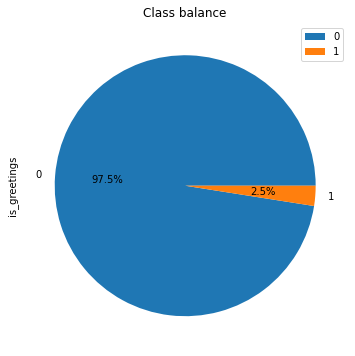

In [ ]:
plt.figure(figsize=(6, 6))
df_class.is_greetings.value_counts(normalize = True).plot(kind = 'pie', autopct='%1.1f%%')
plt.title('Class balance')
plt.legend()
plt.show()

Подготовим функцию для очистки текста.

In [ ]:
def clear_text(text):
    text = re.sub(r'[^а-яА-Я \']', ' ', text).split()
    return ' '.join(text)

Применим ее и создадим новый столбец clear_text с очищенным текстом.

In [ ]:
%%time

df_class['clear_text'] = df_class['text'].apply(clear_text)

Wall time: 2 ms


In [ ]:
df_class.head()

,dlg_id,text,is_greetings,clear_text
1,0,алло здравствуйте,1,алло здравствуйте
3,0,меня зовут ангелина компания диджитал бизнес з...,0,меня зовут ангелина компания диджитал бизнес з...
5,0,угу ну возможно вы рассмотрите и другие вариан...,0,угу ну возможно вы рассмотрите и другие вариан...
8,0,угу а на что вы обращаете внимание при выборе,0,угу а на что вы обращаете внимание при выборе
11,0,что для вас приоритет,0,что для вас приоритет


Далее мы приведем все слова к начальной форме. Так как мы работаем с русским языком, то нам подойдет библиотека pymorphy2.

In [ ]:
morph = pymorphy2.MorphAnalyzer()

Создаем новый столбец lemm_text, содердащий слова в начальной форме.

In [ ]:
%%time
df_class['lemm_text'] = df_class['clear_text'].apply(lambda sentence: " ".join([morph.parse(word)[0].normal_form for word in sentence.split()]))

Wall time: 448 ms


In [ ]:
df_class.head()

,dlg_id,text,is_greetings,clear_text,lemm_text
1,0,алло здравствуйте,1,алло здравствуйте,алло здравствуйте
3,0,меня зовут ангелина компания диджитал бизнес з...,0,меня зовут ангелина компания диджитал бизнес з...,я звать ангелина компания диджитал бизнес звон...
5,0,угу ну возможно вы рассмотрите и другие вариан...,0,угу ну возможно вы рассмотрите и другие вариан...,угу ну возможно вы рассмотреть и другой вариан...
8,0,угу а на что вы обращаете внимание при выборе,0,угу а на что вы обращаете внимание при выборе,угу а на что вы обращать внимание при выбор
11,0,что для вас приоритет,0,что для вас приоритет,что для вы приоритет


Далее произведем проверку с помощью облака слов, посмотрим, насколько хороша прошла лемматизация и какие слова наиболее часто встречаются.

In [ ]:
words = ' '.join(df_class['lemm_text'])

In [ ]:
cloud = WordCloud().generate(words)

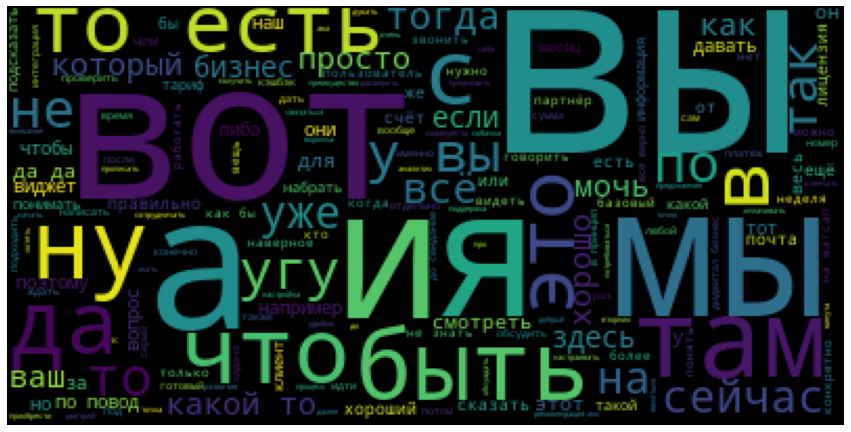

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

Все слова приведены к начальной форме. Много предлогов, но от большинства из них получится избавиться на этапе векторизации.

Определим целевую переменую и обучающую фичу.

In [ ]:
target = df_class['is_greetings']
features = df_class['lemm_text']

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Админ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Разобъем наш датафрейм на тренироввочную и тестовую в соотношении 80:20.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

Уравновесим классы с помощью upsampling.

Найдем значение параметра k.

In [ ]:
k = round(df_class.is_greetings.value_counts()[0] / df_class.is_greetings.value_counts()[1])

In [ ]:
print(f'k равно: {k}')

k равно: 39


In [ ]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=42)
    target_upsampled = shuffle(target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

    
    
features_upsampled, target_upsampled = upsample(features_train, target_train, repeat = k)

print(features_upsampled.shape)
print(target_upsampled.shape)

(312,)
(312,)


Используем юникод для подачи в векторизатор.

In [ ]:
features_train = features_upsampled.values.astype('U')

Теперь можно создать признаки, с помощью которых наши модели будут обучаться. Для этого переведем тексты реплик в векторный формат. Воспользуемся статистической мерой TF-IDF, которую можно использовать для оценки важности слова в тексте.

Но перед этим удалим слова, которые не несут смысловую нагрузку в тексте - местоимения, междометия, предлоги и т.д. для того, чтобы при создании признаков уменьшить их громозкость.

Создадим счетчик, указав в нем стоп-слова.

In [ ]:
stopwords = set(nltk_stopwords.words('russian'))

Для валидационной и тестовой выборки воспользуемся только функцией transform для объективности.

Обучим 2 модели:

* Logistic Regression
* Random Forest Classifer

Посмотрим, какая из них справится лучше.

Для того, чтобы при поиске наилучших параметров модели не происходило утечки данных из валидационной части в тренироввочную, мы используем пайплайн. В пайплайн мы запишем векторизатор и модель.

In [ ]:
lr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('lr_clf', LogisticRegression(random_state=42, class_weight='balanced'))])

svc_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('svc_clf', SVC(random_state=42, class_weight = 'balanced', kernel = 'linear'))])

**Logistic Regression**

Начнем обучение на модели Logistic Regression. Воспользуемся GridSearchCV для перебора параметров.

In [ ]:
parameters = { 
              'lr_clf__solver':['lbfgs', 'liblinear'],
              'lr_clf__class_weight':[None, 'balanced'],
              'lr_clf__max_iter':range (4500, 6000, 500)
              }

In [ ]:
model_gs_lr = GridSearchCV(lr_ppl_clf, parameters, cv=3, scoring='f1', n_jobs=-1)

In [ ]:
%%time
model_gs_lr.fit(features_train, target_upsampled)
print(f'Лучшие параметры логистической регрессии:')
print()
print(model_gs_lr.best_params_)
print()
print()
print('Лучший F1 cross score')
print()      
print(model_gs_lr.best_score_)

Лучшие параметры логистической регрессии:

{'lr_clf__class_weight': None, 'lr_clf__max_iter': 4500, 'lr_clf__solver': 'lbfgs'}


Лучший F1 cross score

1.0
Wall time: 1.75 s


Модель показала 100% значение гармонического среднего между полнотой и точностью.

**Support Vector Classifier**

Перейдем теперь к модели метода опорных векторов SVC. Также используем GidSearchCV для перебора параметров.

In [ ]:
parametr_svc = {
    'svc_clf__C': [1, 2]
}

In [ ]:
model_gs_svc = GridSearchCV(svc_ppl_clf, parametr_svc, cv=3, scoring='f1', n_jobs=-1)

In [ ]:
%%time
model_gs_svc.fit(features_train, target_upsampled)
print(f'Лучшие параметры метода опорных векторов:')
print()
print(model_gs_svc.best_params_)
print()
print()
print('Лучший F1 cross score')
print()      
print(model_gs_svc.best_score_)

Лучшие параметры метода опорных векторов:

{'svc_clf__C': 1}


Лучший F1 cross score

1.0
Wall time: 45 ms


Оба метода показали одинаково хороший результат. Воспользуемся Support Vector Classifier для тестирования модели.

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

In [ ]:
features_train_tf_idf = count_tf_idf.fit_transform(features_train)

Для тестовой выборки воспользуемся только функцией transform для объективности.

In [ ]:
features_test_tf_idf = count_tf_idf.transform(features_test.values.astype('U'))

Посмотрим размерности.

In [ ]:
features_train_tf_idf.shape, features_test_tf_idf.shape

((312, 381), (41, 381))

In [ ]:
model_svc = SVC(random_state = 42, C=1)

In [ ]:
model_svc.fit(features_train_tf_idf, target_upsampled)

SVC(C=1, random_state=42)

In [ ]:
predictions = model_svc.predict(features_test_tf_idf)

In [ ]:
f1_score(target_test, predictions)

1.0

Результат на тесте также 100%.

# Часть 3

Еще один тест. Попробуем научить рекуррентную нейронную сеть вести диалог, используя имеющиеся диалоги.

In [ ]:
dialogs = []

for i in data.dlg_id.unique():
    dlg = data[data.dlg_id == i]
    dialogs.append(dlg)

In [ ]:
input_texts = []
target_texts = []

In [ ]:
for dlg in dialogs:
    for i, phrase in enumerate(dlg.text.values):
        if i != len(dlg.text.values) - 1:
            input_texts.append(phrase)
        if i != 0:
            target_texts.append(phrase)

Проверяем чтобы количество фраз и ответов на фразы было одинаковым.

In [ ]:
len(input_texts) == len(target_texts)

True

Посмотрим пример, получившихся пар фраз.

In [ ]:
print(input_texts[135])
print(target_texts[135])

ну вот сейчас секунду тут есть фильтр сейчас
да вот где раздел как для админа там вам нужно будет туда зайти и там будет количество пользователей там где активировать


Займемся подготовкой словаря
В качестве элемента последовательности будем использовать одно слово
Подготовим два словаря (отображения индекса в слово и слова в индекс)

In [ ]:
def prepare_vocab(texts):
    vocab = []
    for i in texts:
        words = i.split()
        vocab = vocab + words
    vocab.append('<START>')
    vocab.append('<END>')
    vocab.append(' ')
    vocab = set(vocab)
    vocab_size = len(vocab)
    char2idx = {u:i for i, u in enumerate(vocab)}
    idx2char = {v:k for k, v in char2idx.items()}
    return vocab_size, char2idx, idx2char

In [ ]:
VOCAB_SIZE, char2idx, idx2char = prepare_vocab(input_texts + target_texts)

Оценим величину получившегося словаря.

In [ ]:
print(VOCAB_SIZE)

1179


In [ ]:
input_texts_as_int = [[char2idx[c] for c in text.split(' ')] for text in input_texts]
target_texts_as_int = [[char2idx[c] for c in text.split(' ')] for text in target_texts]

encoder_input_seqs = [np.array(text) for text in input_texts_as_int]
decoder_input_seqs = []
decoder_target_seqs = []
for target_text in target_texts_as_int:
    decoder_input_seqs.append(np.array([char2idx['<START>']] + target_text))
    decoder_target_seqs.append(np.array(target_text + [char2idx['<END>']]))

In [ ]:
max_enc_seq_length = max([len(seq) for seq in encoder_input_seqs])
max_dec_seq_length = max([len(seq) for seq in decoder_input_seqs])

encoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    encoder_input_seqs,
    value=char2idx[' '],
    padding='post',
    maxlen=max_enc_seq_length
)

decoder_input_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_input_seqs,
    value=char2idx[' '],
    padding='post',
    maxlen=max_dec_seq_length
)

decoder_target_seqs = tf.keras.preprocessing.sequence.pad_sequences(
    decoder_target_seqs,
    value=char2idx[' '],
    padding='post',
    maxlen=max_dec_seq_length
)

In [ ]:
H_SIZE = 256
EMB_SIZE = 256

class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE)
        self.lstm = tf.keras.layers.LSTM(H_SIZE, return_sequences=False, return_state=True)
        
    def call(self, x):
        out = self.embed(x)
        _, h, c = self.lstm(out)
        state = (h, c)
        return state

    
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE)
        self.lstm = tf.keras.layers.LSTM(H_SIZE, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')
        
    def call(self, x, init_state):
        out = self.embed(x)
        out, h, c = self.lstm(out, initial_state=init_state)
        out = self.fc(out)
        state = (h, c)
        return out, state


encoder_model = Encoder()
decoder_model = Decoder()

encoder_inputs = tf.keras.layers.Input(shape=(None,))
decoder_inputs = tf.keras.layers.Input(shape=(None,))

enc_state = encoder_model(encoder_inputs)
decoder_outputs, _ = decoder_model(decoder_inputs, enc_state)

seq2seq = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 40

loss = tf.losses.SparseCategoricalCrossentropy()
seq2seq.compile(optimizer='rmsprop', loss=loss, metrics=['accuracy'])

seq2seq.fit([encoder_input_seqs, decoder_input_seqs], decoder_target_seqs, batch_size=BATCH_SIZE, 
            epochs=EPOCHS)

Epoch 1/40
8/8 [==============================] - 10s 1s/step - loss: 0.5469 - accuracy: 0.9242
Epoch 2/40
8/8 [==============================] - 8s 1s/step - loss: 0.4433 - accuracy: 0.9268
Epoch 3/40
8/8 [==============================] - 8s 1s/step - loss: 0.4327 - accuracy: 0.9279
Epoch 4/40
8/8 [==============================] - 8s 1s/step - loss: 0.4274 - accuracy: 0.9284
Epoch 5/40
8/8 [==============================] - 8s 987ms/step - loss: 0.4227 - accuracy: 0.9288
Epoch 6/40
8/8 [==============================] - 8s 1s/step - loss: 0.4197 - accuracy: 0.9294
Epoch 7/40
8/8 [==============================] - 8s 1s/step - loss: 0.4159 - accuracy: 0.9297
Epoch 8/40
8/8 [==============================] - 8s 1s/step - loss: 0.4118 - accuracy: 0.9299
Epoch 9/40
8/8 [==============================] - 8s 990ms/step - loss: 0.4077 - accuracy: 0.9304
Epoch 10/40
8/8 [==============================] - 9s 1s/step - loss: 0.4045 - accuracy: 0.9306
Epoch 11/40
8/8 [=========================

In [ ]:
def seq2seq_inference(input_seq):
    state = encoder_model(input_seq)

    target_seq = np.array([[char2idx['<START>']]])

    decoded_sentence = ''
    while True:
        output_tokens, state = decoder_model(target_seq, state)

        temperature = 0.25
        pred = output_tokens / temperature
        pred_c = tf.random.categorical(pred[0, ...], num_samples=1)[-1][0].numpy()
        sampled_char = idx2char[pred_c]
        
        
        

        sampled_token_index = np.argmax(output_tokens[0, -1, :])


        decoded_sentence += sampled_char
        decoded_sentence += ' '

        if (sampled_char == '<END>' or
           len(decoded_sentence) > max_dec_seq_length):
            break

        target_seq = np.array([[pred_c]])

    return decoded_sentence

In [ ]:
for seq_index in range(0, 10):
    input_seq = encoder_input_seqs[seq_index: seq_index + 1]
    decoded_sentence = seq2seq_inference(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Result sentence:', decoded_sentence)
    print('Target sentence:', target_texts[seq_index])

-
Input sentence: алло
Result sentence: тем ираклас развития покупали очистим звонит видит сотрудничество чем отвечает галочки рабочего странно случаю устраивает отлично неделю раздел отработать 
Target sentence: алло здравствуйте
-
Input sentence: алло здравствуйте
Result sentence: ответ да карточку ряд более начала вещи настройки специалист планируете информацию событий позвоните оплату поможет нет собственно важно движет вопрос 
Target sentence: добрый день
-
Input sentence: добрый день
Result sentence: сориентировали подскажите пользователя вечера форму сделал вне важно покажите передам севере принимаем сделано пробить перепутала легко вещи чат тоже 
Target sentence: меня зовут ангелина компания диджитал бизнес звоним вам по поводу продления лицензии а мы с серым у вас скоро срок заканчивается
-
Input sentence: меня зовут ангелина компания диджитал бизнес звоним вам по поводу продления лицензии а мы с серым у вас скоро срок заканчивается
Result sentence: вручную февраля давать 2 об

Вот примерно какие выдает фразы нейронная сеть.
Разумеется, дальнейшая работа с базой, с варьированием параметра temperature, c параметрами обучения может оказывать благоприятное действие на результат ее работы.